In [593]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Filename for saved plots

In [594]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

In [595]:
fn = path_measurement_data / 'SourceData_Yli_Juuti2021.xls'

df_hyy_1 = pd.read_excel(fn, sheet_name=4, header=1,)# usecols=range(7,12),nrows=7)

df_hyy_1.head()

,year,month,day,LAT,LON,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
0,2012,7,5,60.5,22.5,3.218589,191,12.940000,26.219999
1,2012,7,10,60.5,22.5,4.714353,172,10.950000,24.430000
2,2012,7,14,60.5,22.5,1.451827,106,15.790000,12.030000
3,2012,7,19,60.5,22.5,3.101941,262,16.039999,28.650000
4,2012,7,22,60.5,22.5,0.875789,92,10.630000,14.820000


In [596]:
import pandas as pd

In [597]:
df_hyy_1['date'] = df_hyy_1.apply(lambda x: f'{x.year:.0f}-{x.month:02.0f}-{x.day:02.0f}', axis=1)

df_hyy_1['date'] = pd.to_datetime(df_hyy_1['date'] )

df_hyy_1 = df_hyy_1.set_index(['date','LAT','LON'])

In [598]:
df_hyy_1.index = df_hyy_1.index.rename({'LAT':'lat', 'LON':'lon','date':'time'})

In [599]:
df_hyy_1

,,,year,month,day,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
time,lat,lon,,,,,,,
2012-07-05,60.5,22.5,2012,7,5,3.218589,191,12.940000,26.219999
2012-07-10,60.5,22.5,2012,7,10,4.714353,172,10.950000,24.430000
2012-07-14,60.5,22.5,2012,7,14,1.451827,106,15.790000,12.030000
2012-07-19,60.5,22.5,2012,7,19,3.101941,262,16.039999,28.650000
2012-07-22,60.5,22.5,2012,7,22,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
2018-08-13,65.5,29.5,2018,8,13,0.674785,191,15.200000,18.969999
2018-08-14,65.5,29.5,2018,8,14,1.356364,291,15.200000,31.449999
2018-08-19,65.5,29.5,2018,8,19,0.916047,139,18.230000,11.960000


### High OA vs low OA in observations
Middle OA is already removed in observations

In [600]:
#df_hyy_1['OA_category']

df_hyy_1['OA_low']= df_hyy_1['OA (microgram m^-3)']<2
df_hyy_1['OA_high']= df_hyy_1['OA (microgram m^-3)']>2
ddf_hyy_1=df_hyy_1.assign(OA_category= pd.NA)
df_hyy_1.loc[df_hyy_1['OA_high'], 'OA_category'] = 'OA high'
df_hyy_1.loc[df_hyy_1['OA_low'], 'OA_category'] = 'OA low'



#### Original binning from Yli-Juuti et al:

In [601]:
bins = pd.IntervalIndex.from_tuples([(60, 100), (100, 140), (140, 180), (180, 220), (220, 260), (260, 300), (300, 340)])

labels=[ 80, 120, 160, 200, 240, 280, 320]

df_hyy_1['CWP_cut']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins, labels=labels)
# label for each bin
df_hyy_1['CWP_cutl'] = df_hyy_1['CWP_cut'].apply(lambda x:x.mid)

#### Quantile binning

In [602]:
df_hyy_1['CWP_qcut']=pd.qcut(df_hyy_1['CWP (g m^-2)'], 7)#bins=bins, labels=labels)
df_hyy_1['CWP_qcutl'] = df_hyy_1['CWP_qcut'].apply(lambda x:x.mid)
# Label by median in each bin
di = dict(df_hyy_1.groupby('CWP_cut').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cutlm'] = df_hyy_1['CWP_cut'].apply(lambda x:di[x])

## LOAD MY VERSION OF SATELLITE: 

In [603]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [604]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [605]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [606]:
from bs_fdbck.constants import path_measurement_data

## Settings: 

In [607]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'SMR'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [608]:
ds_smr_sat = xr.open_dataset(sat_filename)

In [609]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin([7,8])

In [610]:
ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

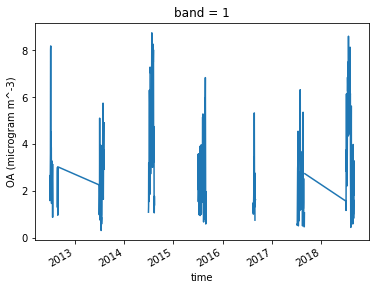

In [611]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [612]:
df_hyy_1.columns

Index(['year', 'month', 'day', 'OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT', 'OA_low', 'OA_high', 'OA_category',
       'CWP_cut', 'CWP_cutl', 'CWP_qcut', 'CWP_qcutl', 'CWP_cutlm'],
      dtype='object')

In [613]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

In [614]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [615]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 434, LAT: 6, LON: 8)
Coordinates:
  * time                 (time) datetime64[ns] 2012-07-01 ... 2018-08-31
  * LAT                  (LAT) float64 65.5 64.5 63.5 62.5 61.5 60.5
  * LON                  (LON) float64 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 2.658 2.658 ... 1.846 1.846
    CWP (g m^-2)         (time, LAT, LON) float32 124.0 132.0 ... 82.0 125.0
    CER (micrometer)     (time, LAT, LON) float32 10.79 11.41 ... 12.57 13.38
    COT                  (time, LAT, LON) float32 18.18 18.75 ... 10.17 14.74

In [616]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [617]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [618]:
df_smr_sat_JAs#.dropna()

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       LAT  LON                                                         
2012-07-01 65.5 22.5             2.657770         124.0         10.790000   
                23.5             2.657770         132.0         11.410000   
                24.5             2.657770         244.0         11.580000   
                25.5             2.657770         337.0         10.889999   
                28.5             2.657770         235.0          9.370000   
...                                   ...           ...               ...   
2018-08-31 60.5 25.5             1.845805          83.0         15.210000   
                26.5             1.845805         243.0         17.139999   
                27.5             1.845805         141.0         14.950000   
                28.5             1.845805          82.0         12.570000   
                29.5             1.845805         125.0         13.380000   

                            COT  
time       LAT  LON              
2012-07-01 65.5 22.5  18.180000  
                23.5  18.750000  
                24.5  33.489998  
                25.5  43.660000  
                28.5  41.299999  
...                         ...  
2018-08-31 60.5 25.5   8.820000  
                26.5  21.740000  
                27.5  14.530000  
                28.5  10.170000  
                29.5  14.740000  

[6693 rows x 4 columns]

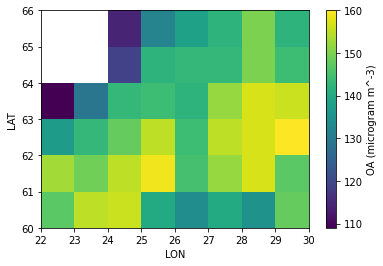

In [619]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>100).notnull()

In [620]:
df_hyy_1_old = df_hyy_1.copy()

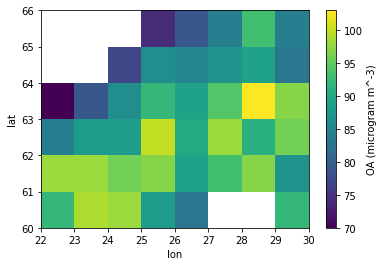

In [621]:
_df = df_hyy_1_old.reset_index()

da_cnt= _df.groupby([_df['lat'],_df['lon']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.plot()
#da_drop_pixels = da_cnt.not_null()
# (da_cnt>100)

In [622]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [695]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


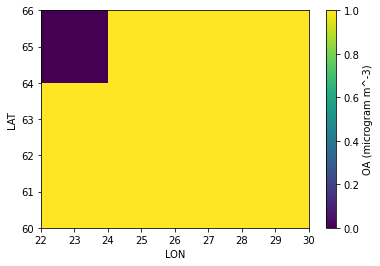

In [623]:
(~da_drop_pixels).plot()

In [624]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

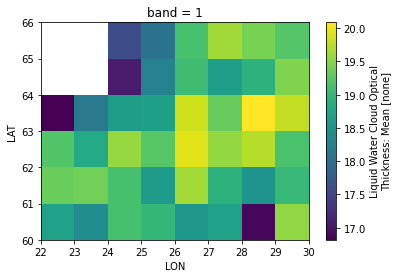

In [625]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([2156., 3432., 2200., 2288., 1056.,  660.,  660.,  616.,  264.,
         308.]),
 array([0.31952647, 1.16273361, 2.00594075, 2.8491479 , 3.69235504,
        4.53556219, 5.37876933, 6.22197647, 7.06518362, 7.90839076,
        8.75159791]),
 <BarContainer object of 10 artists>)

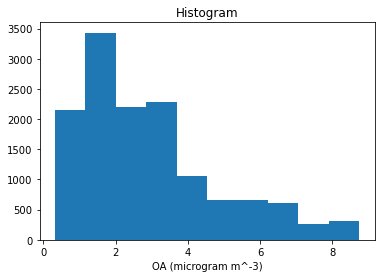

In [626]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [627]:
#df_hyy_1['OA_category']

ds_smr_sat_JAs['OA_low']= ds_smr_sat_JAs['OA (microgram m^-3)']<1.59
ds_smr_sat_JAs['OA_high']= ds_smr_sat_JAs['OA (microgram m^-3)']>3.02

df_smr_sat_JAs = ds_smr_sat_JAs.to_dataframe()

df_smr_sat_JAs=df_smr_sat_JAs.assign(OA_category= pd.NA)
df_smr_sat_JAs.loc[df_smr_sat_JAs['OA_high'], 'OA_category'] = 'OA high'
df_smr_sat_JAs.loc[df_smr_sat_JAs['OA_low'], 'OA_category'] = 'OA low'

#ds_smr_sat_JAs['OA_category'][ds_smr_sat_JAs['OA_high']] = 'OA high'

In [628]:
ds_smr_sat_JAs['OA_category']=df_smr_sat_JAs.to_xarray()['OA_category']

In [629]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [630]:
df_hyy_1

,,,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT,OA_low,OA_high,OA_category
time,lat,lon,,,,,,,
2012-07-01,60.5,22.5,2.657770,NaN,NaN,NaN,False,False,<NA>
2012-07-02,60.5,22.5,1.595669,NaN,NaN,NaN,False,False,<NA>
2012-07-03,60.5,22.5,2.454883,72.0,16.09,7.680000,False,False,<NA>
2012-07-04,60.5,22.5,2.126390,NaN,NaN,NaN,False,False,<NA>
2012-07-05,60.5,22.5,3.374406,191.0,12.94,26.219999,False,True,OA high
...,...,...,...,...,...,...,...,...,...
2018-08-27,65.5,29.5,0.839003,141.0,17.43,13.030000,True,False,OA low
2018-08-28,65.5,29.5,1.518961,NaN,NaN,NaN,True,False,OA low
2018-08-29,65.5,29.5,1.565183,NaN,NaN,NaN,True,False,OA low


#### Original binning from Yli-Juuti et al:

In [631]:
bins = pd.IntervalIndex.from_tuples([(60, 100), (100, 140), (140, 180), (180, 220), (220, 260), (260, 300), (300, 340)])

labels=[ 80, 120, 160, 200, 240, 280, 320]

df_hyy_1['CWP_cut']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins, labels=labels)
# label for each bin
df_hyy_1['CWP_cutl'] = df_hyy_1['CWP_cut'].apply(lambda x:x.mid)

#### Quantile binning

In [632]:
df_hyy_1['CWP_qcut']=pd.qcut(df_hyy_1['CWP (g m^-2)'], 7)#bins=bins, labels=labels)
df_hyy_1['CWP_qcutl'] = df_hyy_1['CWP_qcut'].apply(lambda x:x.mid)
# Label by median in each bin
di = dict(df_hyy_1.groupby('CWP_cut').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cutlm'] = df_hyy_1['CWP_cut'].apply(lambda x:di[x])

#### Bin from 5th to 95th quantile of CWP and label by median in each bin or just number

In [633]:
n_bins = 7
labels = np.arange(n_bins)

qants = df_hyy_1['CWP (g m^-2)'].quantile([.05,.95])

bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)

df_hyy_1['CWP_cut2']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins2, labels=labels)


di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

df_hyy_1['CWP_cut2l'] = df_hyy_1['CWP_cut2'].apply(lambda x:di_per_lab[x])


di = dict(df_hyy_1.groupby('CWP_cut2').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lm'] = df_hyy_1['CWP_cut2'].apply(lambda x:di[x])
#di = dict(df_hyy_1.groupby('CWP_cut2').mid)
#for k in di.keys():
#    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lmid'] = df_hyy_1['CWP_cut2'].apply(lambda x:np.round(x.mid))


#df_hyy_1['CWP_cut2lmid'] = df_hyy_1['CWP_cut2'].apply(lambda x:x.mid)

<AxesSubplot:ylabel='Frequency'>

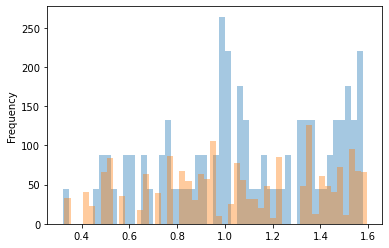

In [634]:
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')



df_hyy_1_old['OA (microgram m^-3)'][df_hyy_1_old['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')



In [635]:
df_hyy_1['OA (microgram m^-3)'].quantile([.33,.64])

0.33    1.729960
0.64    3.126882
Name: OA (microgram m^-3), dtype: float64

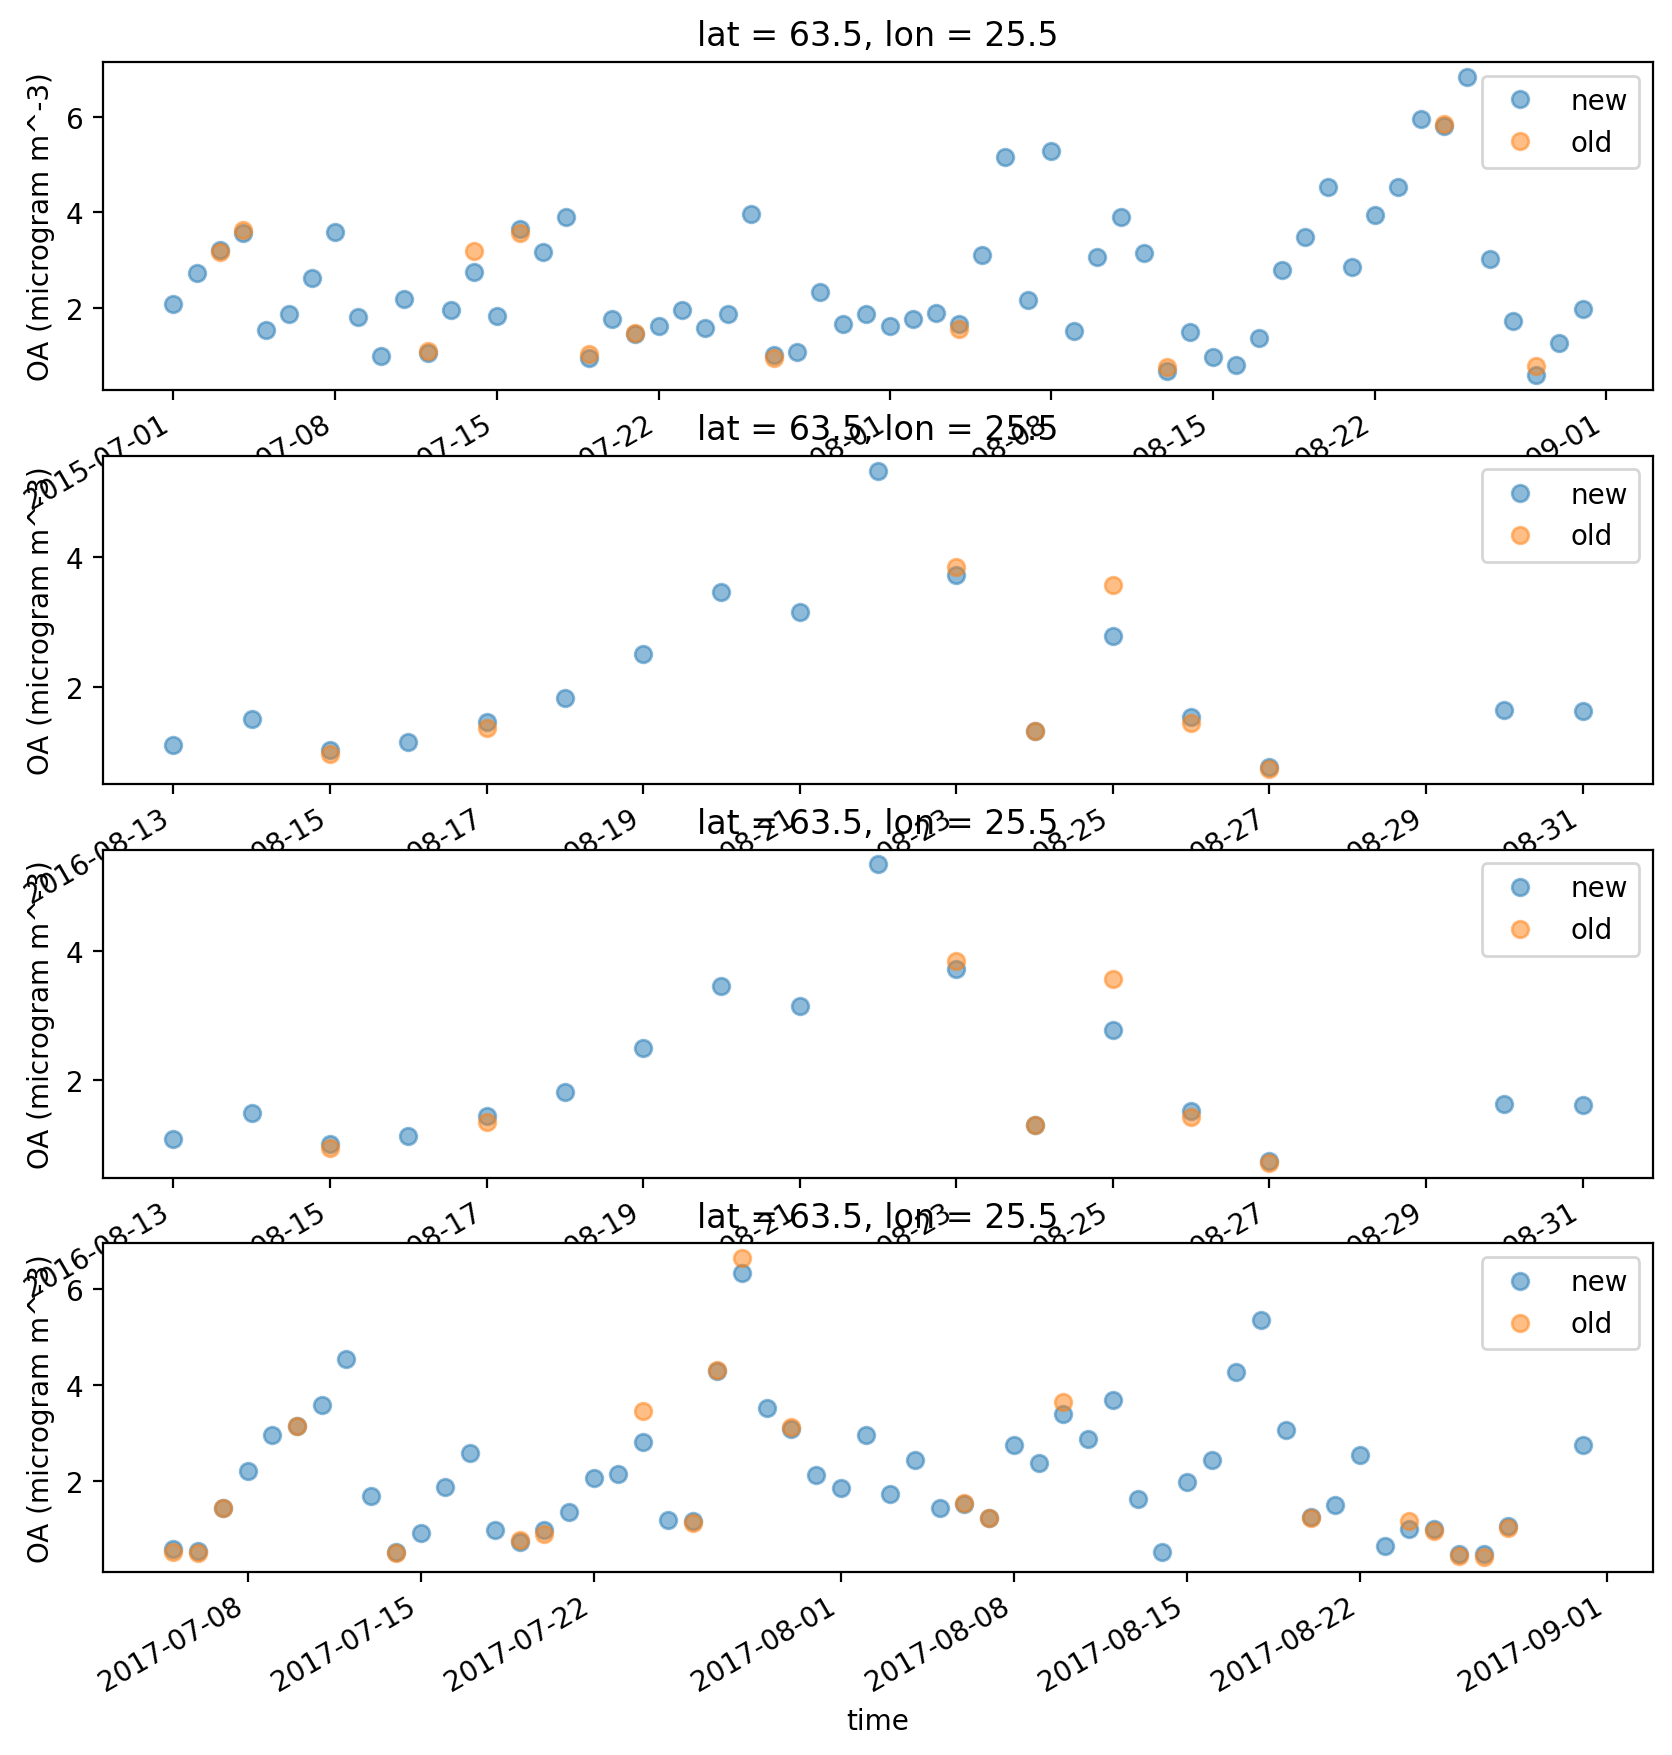

In [636]:
fig, axs = plt.subplots(4,dpi=200, figsize=[10,10])
ax = axs[0]
df_hyy_1.to_xarray()['OA (microgram m^-3)'].sortby('time').isel(lat=3,lon=3).sel(time=slice('2015-07','2015-08')).plot(marker='o', alpha=.5, label='new', linewidth=0, ax=axs[0])
df_hyy_1_old.to_xarray()['OA (microgram m^-3)'].isel(lat=3,lon=3).sel(time=slice('2015-07','2015-08')).plot(marker='o', alpha=.5, label='old', linewidth=0, ax=axs[0])

ax.legend()
ax = axs[1]

df_hyy_1.to_xarray()['OA (microgram m^-3)'].sortby('time').isel(lat=3,lon=3).sel(time=slice('2016-07','2016-08')).plot(marker='o', alpha=.5, label='new', linewidth=0, ax=axs[1])
df_hyy_1_old.to_xarray()['OA (microgram m^-3)'].isel(lat=3,lon=3).sel(time=slice('2016-07','2016-08')).plot(marker='o', alpha=.5, label='old', linewidth=0, ax=axs[1])

ax.legend()

ax = axs[2]
df_hyy_1.to_xarray()['OA (microgram m^-3)'].sortby('time').isel(lat=3,lon=3).sel(time=slice('2016-07','2016-08')).plot(marker='o', alpha=.5, label='new', linewidth=0, ax=ax)
df_hyy_1_old.to_xarray()['OA (microgram m^-3)'].isel(lat=3,lon=3).sel(time=slice('2016-07','2016-08')).plot(marker='o', alpha=.5, label='old', linewidth=0, ax=ax)

ax.legend()

ax = axs[3]
df_hyy_1.to_xarray()['OA (microgram m^-3)'].sortby('time').isel(lat=3,lon=3).sel(time=slice('2017-07','2017-08')).plot(marker='o', alpha=.5, label='new', linewidth=0, ax=ax)
df_hyy_1_old.to_xarray()['OA (microgram m^-3)'].isel(lat=3,lon=3).sel(time=slice('2017-07','2017-08')).plot(marker='o', alpha=.5, label='old', linewidth=0, ax=ax)

ax.legend()

#['OA (microgram m^-3)'][df_hyy_1_old['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')



<AxesSubplot:ylabel='Frequency'>

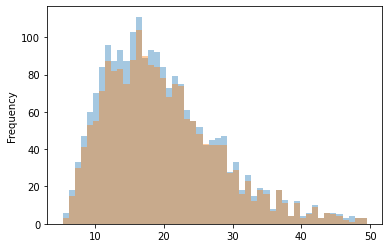

In [637]:
df_hyy_1['COT'][df_hyy_1['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')
df_hyy_1_old['COT'][df_hyy_1_old['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')

<AxesSubplot:ylabel='Frequency'>

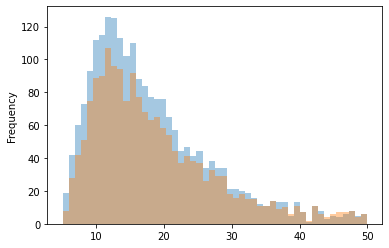

In [638]:
df_hyy_1['COT'][df_hyy_1['OA_high']].plot.hist(bins=50, alpha=0.4, label='obs')
df_hyy_1_old['COT'][df_hyy_1_old['OA_high']].plot.hist(bins=50, alpha=0.4, label='obs')

In [639]:
ma_OA = df_hyy_1['OA_category'].notna()

<AxesSubplot:ylabel='Frequency'>

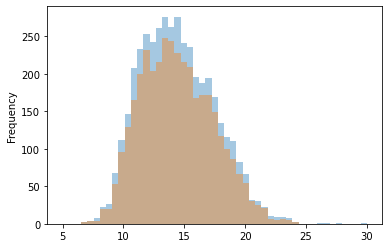

In [640]:
v = 'CER (micrometer)'
bins=np.linspace(5,30)
df_hyy_1[v][ma_OA].plot.hist( alpha=0.4, label='obs', bins=bins)
df_hyy_1_old[v].plot.hist( alpha=0.4, label='obs', bins = bins)

In [641]:
vs =['OA (microgram m^-3)', 'CWP (g m^-2)', 'CER (micrometer)', 'COT',
       'OA_low', 'OA_high', 'OA_category']

<AxesSubplot:ylabel='Frequency'>

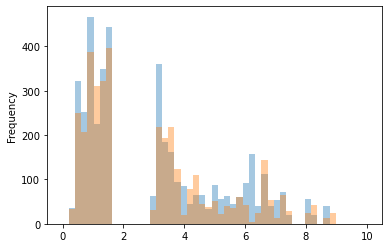

In [642]:
is_na = df_hyy_1[ma_OA][vs].isnull().any(axis=1)
is_na

v = 'OA (microgram m^-3)'
bins = np.linspace(0,10,50)
df_hyy_1[v][(ma_OA)][(~is_na)].plot.hist(bins=bins, alpha=0.4, label='obs')
df_hyy_1_old[v].plot.hist(bins=bins, alpha=0.4, label='obs')

In [643]:
len(df_hyy_1[v][(ma_OA)][(~is_na)])

4264

In [644]:
len(df_hyy_1_old)

3673

In [645]:
df_hyy_1.columns

Index(['OA (microgram m^-3)', 'CWP (g m^-2)', 'CER (micrometer)', 'COT',
       'OA_low', 'OA_high', 'OA_category', 'CWP_cut', 'CWP_cutl', 'CWP_qcut',
       'CWP_qcutl', 'CWP_cutlm', 'CWP_cut2', 'CWP_cut2l', 'CWP_cut2lm',
       'CWP_cut2lmid'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

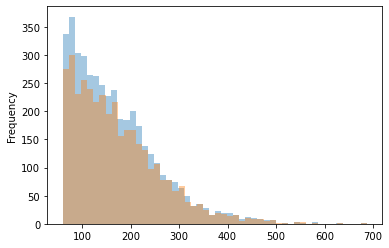

In [646]:
v = 'CWP (g m^-2)'
df_hyy_1[v][ma_OA].dropna().plot.hist(bins=50, alpha=0.4, label='obs')
df_hyy_1_old[v].plot.hist(bins=50, alpha=0.4, label='obs')

<AxesSubplot:ylabel='Frequency'>

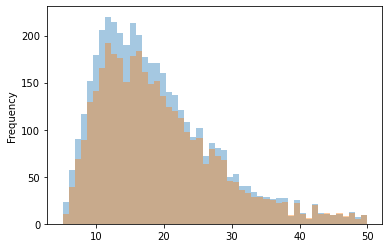

In [647]:
v = 'COT'
df_hyy_1[v][ma_OA].plot.hist(bins=50, alpha=0.4, label='obs')
df_hyy_1_old[v].plot.hist(bins=50, alpha=0.4, label='obs')

df_smr_sat_JAsad model data:

In [648]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 

models =[model_name_noresm,model_name_echam]

### Settings

In [649]:
lon_lims = [22.,30.]
lat_lims = [60.,66.]

lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

temperature = 273.15  # K

### NorESM

In [650]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [651]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files created in [02-create_file-long_sum.ipynb](02-create_file-long_sum)

In [652]:
#fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1_final.csv'

In [653]:
cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [654]:
case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [655]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'22.0-30.0_60.0-66.0'

#### Input files:

In [656]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [657]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

In [658]:

cases_echam = [case_name_echam]

### Read in model data

In [659]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2] )

df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2] )

### Organize data in dictionary

In [660]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df['Observations'] = df_hyy_1

## Mask data

### NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top 

In [661]:
df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

## Rename variables:


In [662]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    
    
}
rn_dic_noresm = {
    'TGCLDCWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}



In [663]:
for key, rn in zip([model_name_noresm, model_name_echam,'Observations'], [rn_dic_noresm, rn_dic_echam, rn_dic_obs]):
    dic_df[key] = dic_df[key].rename(rn, axis=1)

## Group by cloud water path 

#### Predefined bins

In [664]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])

### Bin model data:

CWP above 50. 

In [665]:
varl_categories = ['OA']#,'CLDFREE']

In [666]:
n_bins = 7

for model_name in models:
    print(model_name)
    df_mod = dic_df[model_name]
    

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.95])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    for v in varl_categories:
        q34 = df_mod[v].quantile(.34)
        q66 = df_mod[v].quantile(.66)
        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( df_mod[v].quantile(.34)<df_mod[v]) & (df_mod[v]<df_mod[v].quantile(.66))
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'
        dic_df[model_name] = df_mod

NorESM
ECHAM-SALSA


## Mask data according to month

In [667]:
dic_df[model_name].columns

Index(['ORG_mass', 'airdens', 'aot550nm', 'ccn02', 'ccn10', 'ceff', 'ceff_ct',
       'cl_time', 'clfr', 'cod', 'cwp_orig', 'emi_isop_bio', 'emi_monot_bio',
       'lcdnc', 'mmrtrN100', 'mmrtrN200', 'mmrtrN50', 'T', 'uw', 'vw',
       'lcdnc_ct', 'up_lw', 'up_lw_cs', 'up_lw_cs_noa', 'up_lw_noa', 'up_sw',
       'up_sw_cs', 'up_sw_cs_noa', 'up_sw_noa', 'ceff_um', 'cl_time_ct',
       'diff_v', 'diff_v_argminlev', 'r_eff', 'lcdnc_ct_incld',
       'cwp_incld_orig', 'COT', 'N50', 'N100', 'N200', 'OA', 'cwp', 'CWP',
       'lcdnc_cm3', 'T_C', 'hour', 'month', 'ismonth7', 'ismonth8', 'isJuly',
       'isAug', 'isJA', 'isSummer', 'lev', 'year', 'CWP_cut', 'CWP_cutl',
       'CWP_cutlm', 'CWP_cut2', 'CWP_cut2l', 'CWP_cut2lm', 'CWP_cut2lmid',
       'OA_low', 'OA_high', 'OA_mid_range', 'OA_category'],
      dtype='object')

In [668]:
for model_name in models:
    print(model_name)
    df_mod = dic_df[model_name]
    
    


    ds_mod = df_mod.to_xarray()
    ds_mod = ds_mod.where(ds_mod['isJA'])
    
    _df = ds_mod.to_dataframe()
    dic_df[model_name] = _df[~_df['OA_category'].isna()]#.to_dataframe().dropna()

NorESM
ECHAM-SALSA


## Quantile cut

In [669]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

/tmp/ipykernel_236946/1336522009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
/tmp/ipykernel_236946/1336522009.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)


# Distribution plots:

In [670]:
palette = 'Set2'

In [671]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

8928
Plots/dist_plot/cloud_props_distribution_mod_obs_COT_count.png


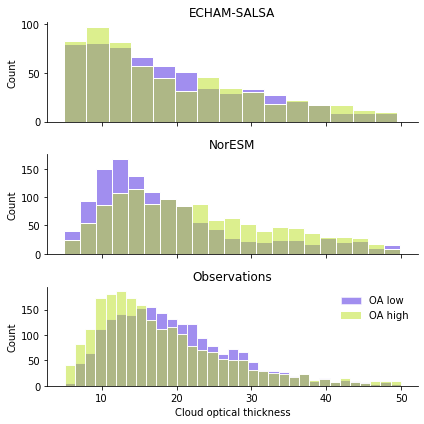

In [672]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



8892
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count.png


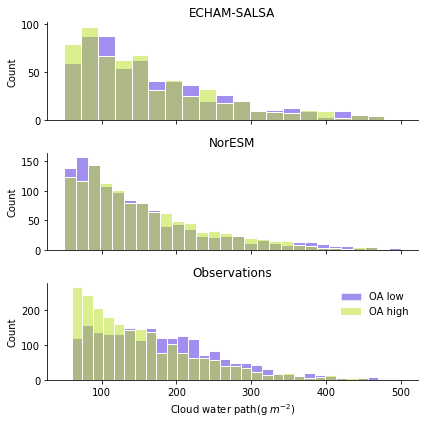

In [673]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6])

v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [674]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

1204

1204
2414
8928
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count.png


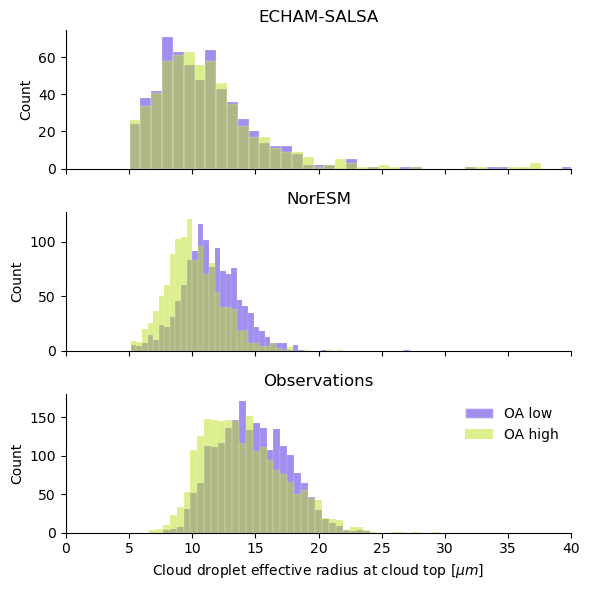

In [675]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



# Calculate difference between high OA and low


In [676]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [677]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [678]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [679]:
from sklearn.utils import resample

## Bootstrap resampling 

In [680]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [681]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations=10000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

length of 77.0 is 149 and 182
10000
length of 118.0 is 151 and 138
10000
length of 163.0 is 102 and 98
10000
length of 212.0 is 73 and 67
10000
length of 260.0 is 45 and 42
10000
length of 296.0 is 27 and 26
10000
length of 353.0 is 23 and 16
10000
length of 72.0 is 396 and 344
10000
length of 112.0 is 273 and 285
10000
length of 154.0 is 207 and 191
10000
length of 198.0 is 111 and 143
10000
length of 240.0 is 62 and 87
10000
length of 280.0 is 52 and 62
10000
length of 323.0 is 34 and 46
10000
length of 87 is 386 and 608
10000
length of 126 is 385 and 442
10000
length of 164 is 330 and 330
10000
length of 202 is 351 and 228
10000
length of 240 is 224 and 159
10000
length of 276 is 140 and 107
10000
length of 316 is 93 and 51
10000
length of 77.0 is 149 and 182
10000
length of 118.0 is 151 and 138
10000
length of 163.0 is 102 and 98
10000
length of 212.0 is 73 and 67
10000
length of 260.0 is 45 and 42
10000
length of 296.0 is 27 and 26
10000
length of 353.0 is 23 and 16
10000
length o

# Final plot: 

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cutl.png


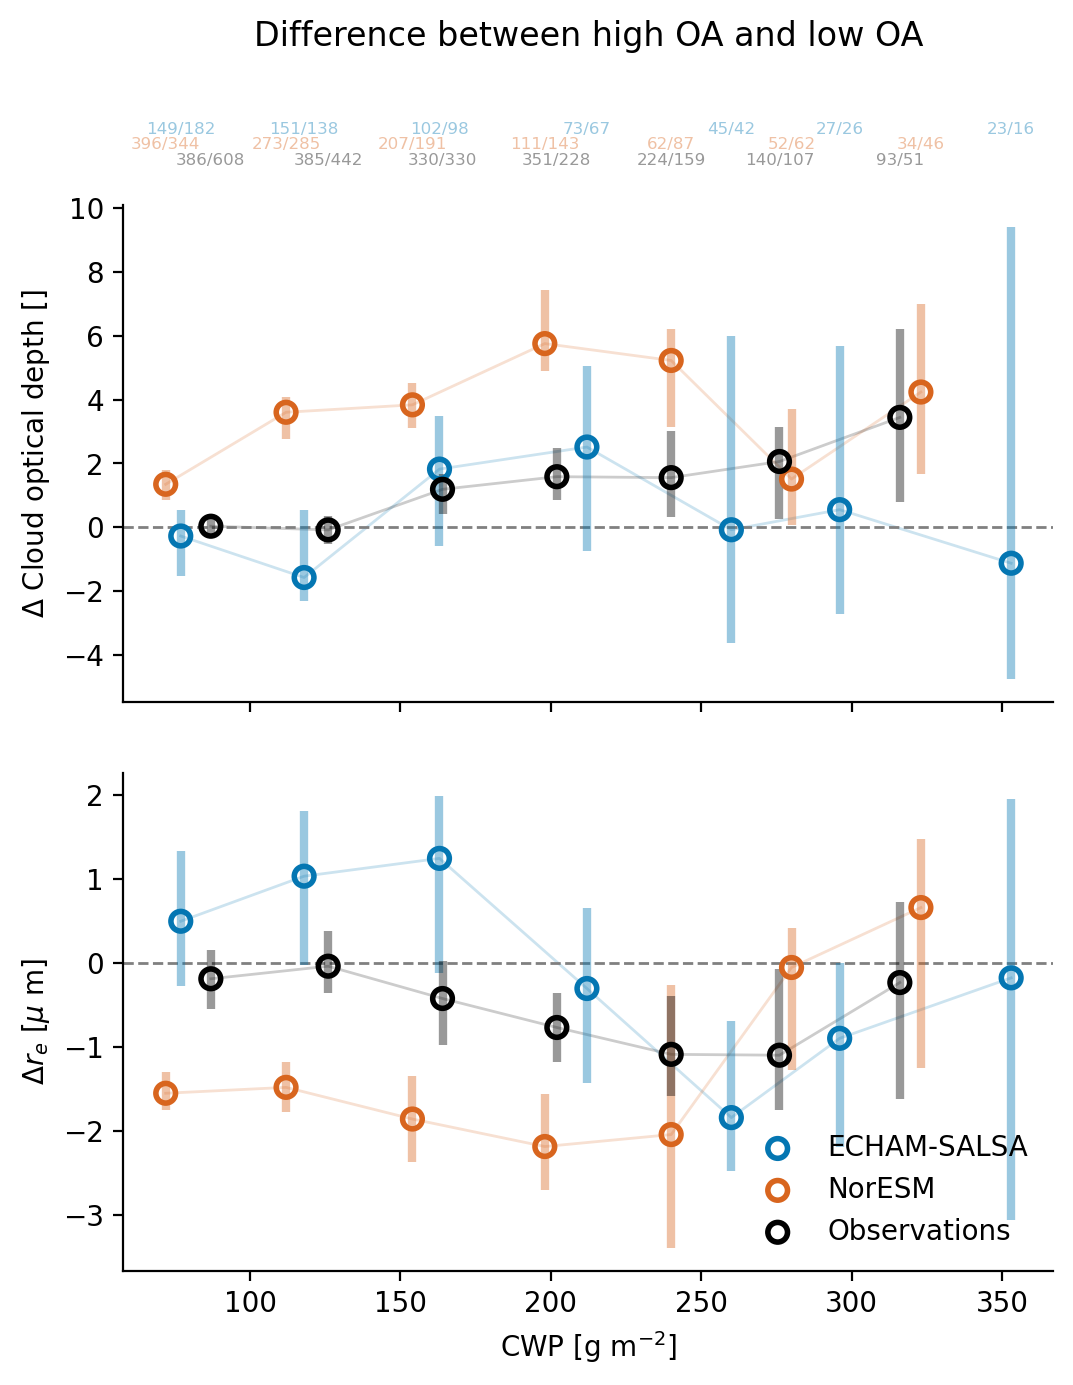

In [682]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cutl'
y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    for key in dic_df.keys():
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=key,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.4,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title('Difference between high OA and low OA')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [683]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [684]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 56.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 48.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl.png


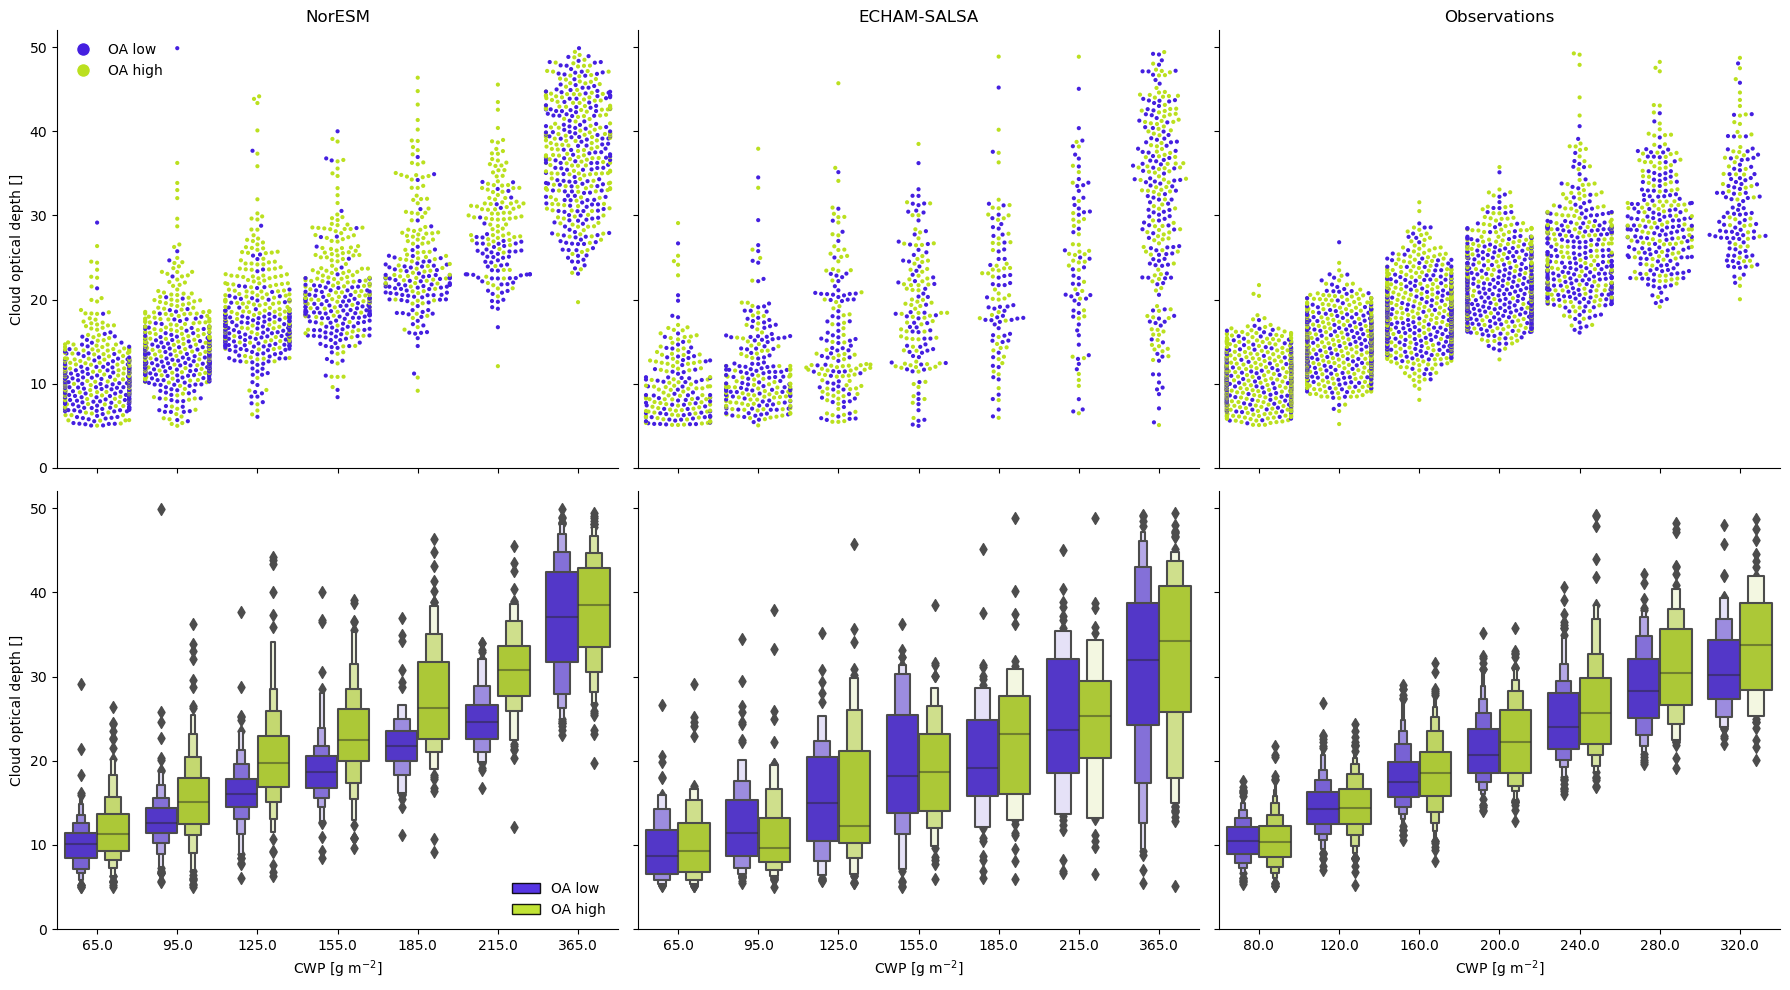

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl.png


In [685]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 3


for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid.png


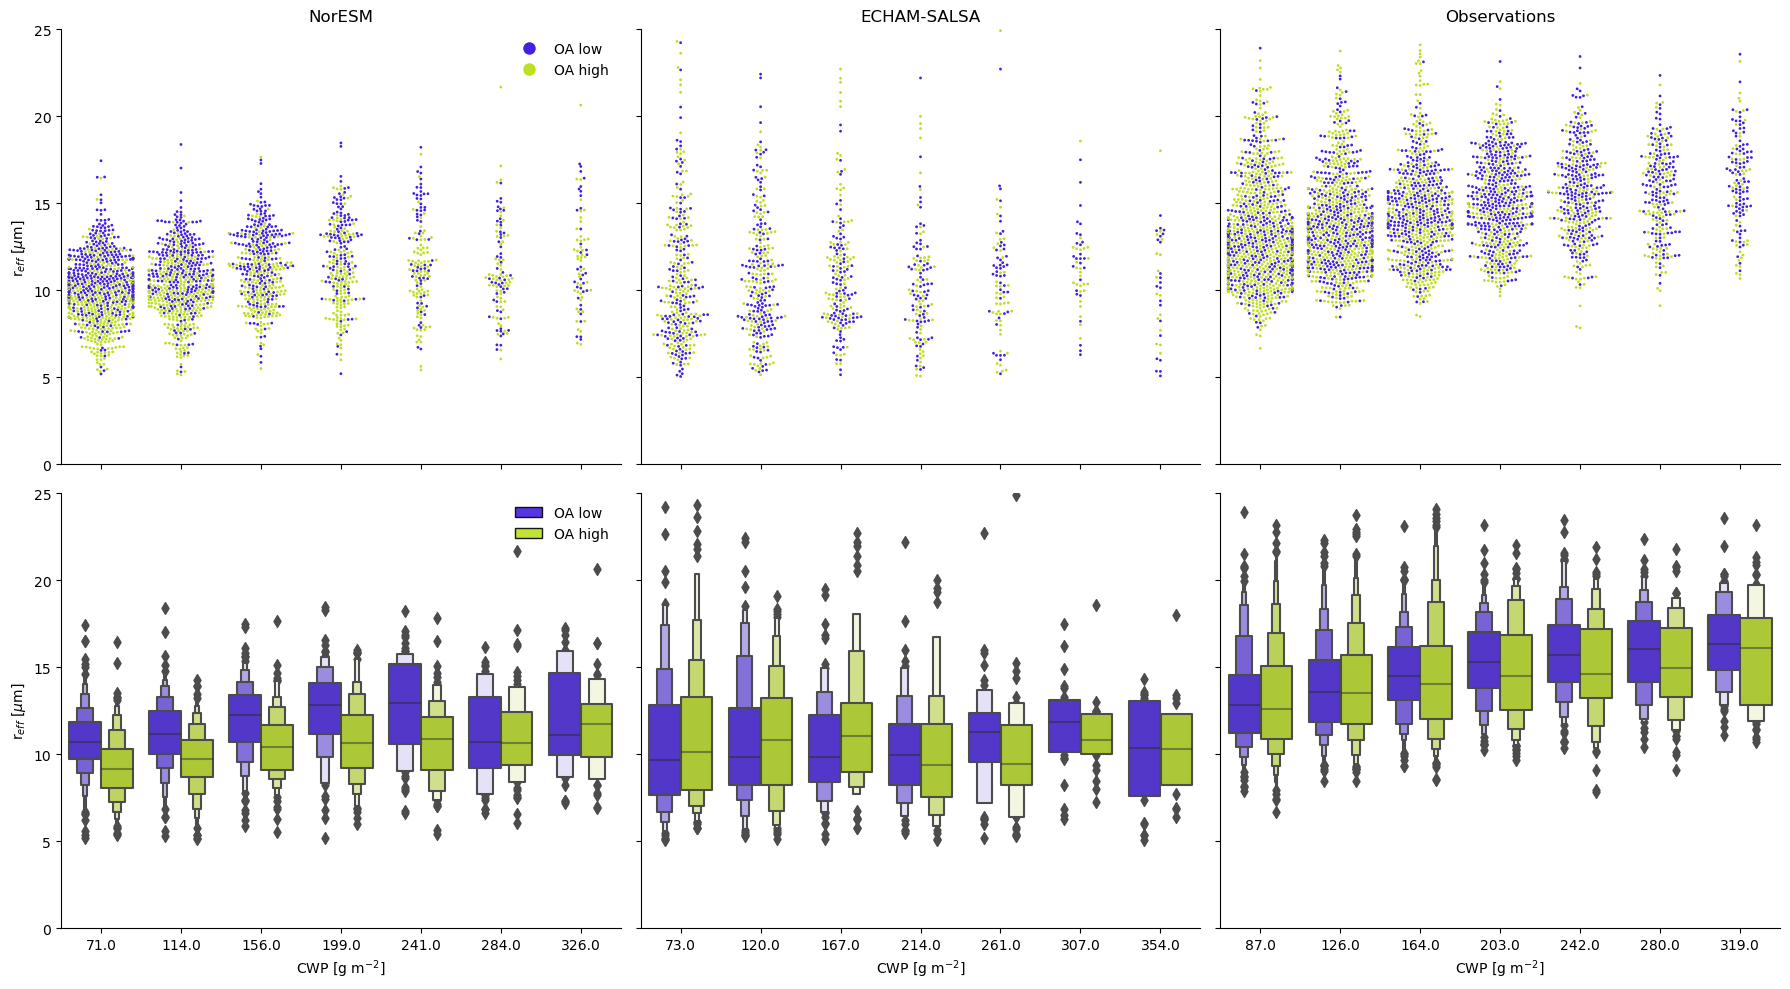

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid.png


In [686]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid.png


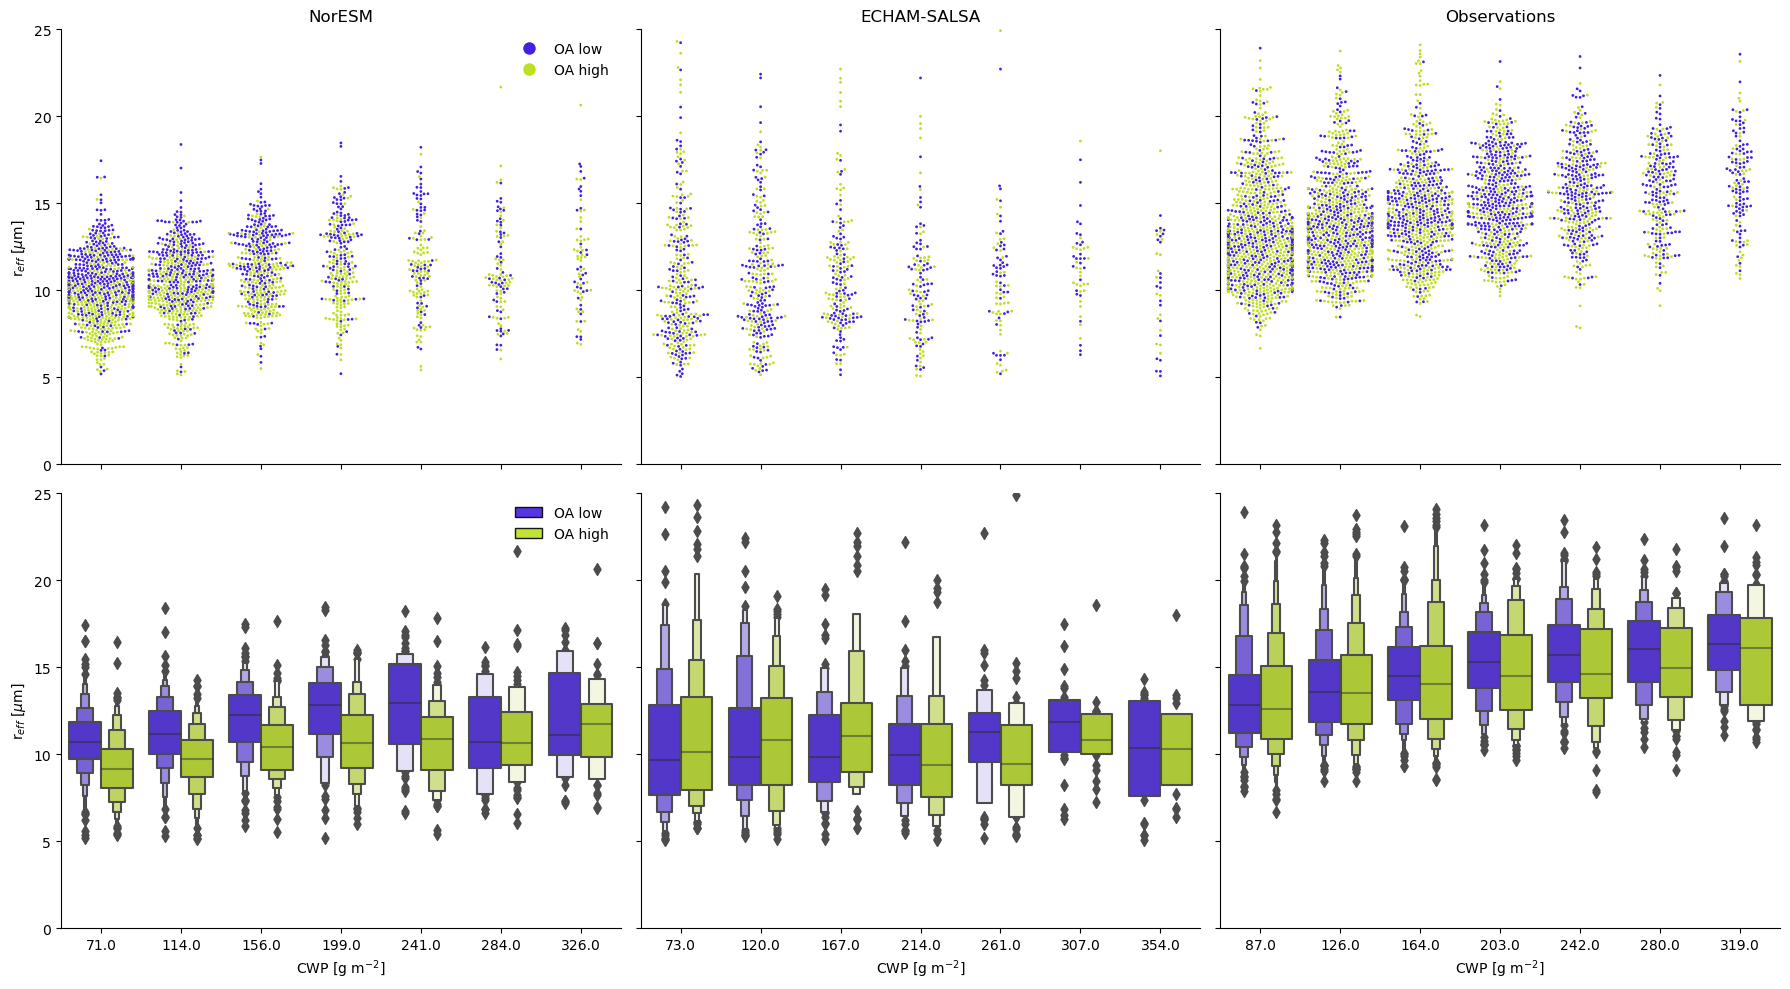

In [687]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

length of 68.0 is 85 and 116
10000
length of 94.0 is 126 and 102
10000
length of 124.0 is 78 and 88
10000
length of 152.0 is 72 and 78
10000
length of 185.0 is 57 and 50
10000
length of 215.0 is 51 and 38
10000
length of 291.0 is 128 and 123
10000


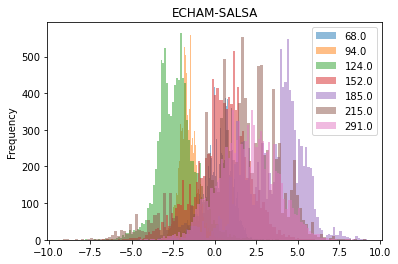

length of 65.0 is 276 and 226
10000
length of 93.0 is 247 and 246
10000
length of 124.0 is 175 and 175
10000
length of 154.0 is 143 and 144
10000
length of 183.0 is 95 and 106
10000
length of 214.0 is 66 and 96
10000
length of 295.0 is 199 and 208
10000


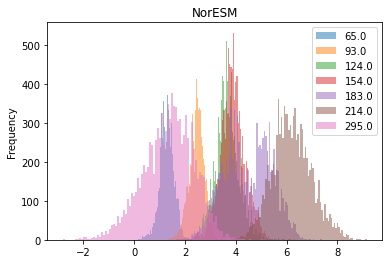

length of 80 is 387 and 668
10000
length of 121 is 398 and 469
10000
length of 160 is 351 and 365
10000
length of 200 is 356 and 237
10000
length of 239 is 239 and 167
10000
length of 276 is 144 and 108
10000
length of 317 is 92 and 51
10000


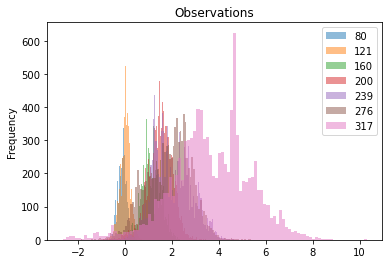

In [688]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 10000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()